In [35]:
import json
import os
from os.path import join
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.networks import zscore_network
from dn_utils.plotting import aligned_imshow_cbar
from bct.algorithms.similarity import corr_flat_und

In [2]:
path_root = os.environ.get('DECIDENET_PATH')

path_derivatives = join(path_root, 'data/main_fmri_study/derivatives')
path_sourcedata = join(path_root, 'data/main_fmri_study/sourcedata') 

path_beh = join(path_sourcedata, 'behavioral')
path_bsc = join(path_derivatives, 'bsc')
path_nistats = join(path_derivatives, 'nistats')
path_parcellations = join(path_derivatives, 'parcellations')

path_corrmats = join(path_bsc, 'corrmats')
Path(path_corrmats).mkdir(exist_ok=True)

In [3]:
atlas = '300_ROI_Set'

# Load behavioral data
beh, meta = load_behavioral_data(path_beh, verbose=False)
n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]
n_perr_sign = 2

# Load betaseries
betaseries_aggregated = np.load(join(
    path_bsc, f'betaseries/{atlas}/betaseries_aggregated.npy'))

# Load ROI table
df_roi = pd.read_csv(join(
    path_parcellations, f'{atlas}/ROIs_300inVol_MNI_allInfo.txt'), sep=' ')

# Load subject exclusion
df_exclusion = pd.read_csv(join(path_nistats, 'exclusion/exclusion.csv'), 
                           index_col=0)

In [4]:
df_roi_coverage = pd.DataFrame(
    np.vstack((np.std(betaseries_aggregated, axis=2)[:, 0, :].astype(bool),
               np.std(betaseries_aggregated, axis=2)[:, 1, :].astype(bool)))
)
df_roi_coverage['sub'] = meta['dim1'] * 2
df_roi_coverage['con'] = [meta['dim2'][0]] * n_subjects \
                       + [meta['dim2'][1]] * n_subjects

included_subjects = list(df_exclusion.loc[df_exclusion['ok_all'], 'sub'])
included_series = df_roi_coverage['sub'].map(lambda sub: sub in included_subjects)

# Filter out excluded betaseries
df_roi_coverage = df_roi_coverage.loc[included_series, :]

included_roi = df_roi_coverage.all(axis=0)[:-2]
excluded_roi = included_roi == False

excluded_roi_list = list(excluded_roi[excluded_roi].index)

# Show excluded ROIs
df_roi.loc[excluded_roi_list]

,x,y,z,radius(mm),netWorkbenchLabel,netName,integrativePercent
0,-56.16,-44.76,-24.23,5,0,unassigned,0.0
2,8.13,41.12,-24.31,5,0,unassigned,0.0
5,51.79,-34.17,-27.23,5,0,unassigned,0.0
9,-50.06,-7.09,-39.24,5,0,unassigned,0.0
95,-17.65,63.19,-9.17,5,1,DefaultMode,0.0
189,33.60,54.22,-12.95,5,3,FrontoParietal,0.0
233,-31.13,-9.99,-36.32,5,17,MedialTemporalLobe,0.0
234,32.85,-12.41,-34.41,5,17,MedialTemporalLobe,0.0
240,-21.14,40.87,-20.48,5,4,Reward,0.0


In [5]:
n_included_roi = sum(included_roi)
corrmats_aggregated = np.zeros(
    (n_subjects, n_conditions, n_perr_sign, n_included_roi, n_included_roi))

for sub_idx, sub in enumerate(meta['dim1']):
    for con_idx, con in enumerate(meta['dim2']):
        
        won_bool_idx = meta['dim4'].index('won_bool')
        won_bool = beh[sub_idx, con_idx, :, won_bool_idx].astype(bool)            
        
        # Split betaseries into +PE and -PE conditions
        betaseries_perr_pos = betaseries_aggregated[sub_idx, con_idx, won_bool][:, included_roi]
        betaseries_perr_neg = betaseries_aggregated[sub_idx, con_idx, ~won_bool][:, included_roi]
        
        # Calculate correlation matrices
        corrmat_perr_pos = zscore_network(np.corrcoef(betaseries_perr_pos.T))
        corrmat_perr_neg = zscore_network(np.corrcoef(betaseries_perr_neg.T))

        corrmats_aggregated[sub_idx, con_idx, 0] = corrmat_perr_pos
        corrmats_aggregated[sub_idx, con_idx, 1] = corrmat_perr_neg
        
path_out = join(path_corrmats, atlas)
Path(path_out).mkdir(exist_ok=True)
# Save matrices and ROI information
np.save(join(path_out, 'corrmats_aggregated.npy'), corrmats_aggregated)
df_roi[included_roi].to_csv(join(path_out, 'roi_table_filtered.csv'))

/home/kmb/miniconda3/envs/decidenet/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/kmb/miniconda3/envs/decidenet/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [33]:
n_mats_per_sub = 4
similarity = np.zeros((n_subjects, n_mats_per_sub, n_mats_per_sub))

for sub_idx in range(n_subjects):
    for ki in range(n_mats_per_sub): 
        for kj in range(n_mats_per_sub):
            i1, j1 = ki // 2, ki % 2
            i2, j2 = kj // 2, kj % 2
            similarity[sub_idx, ki, kj] = corr_flat_und(
                corrmats_aggregated[sub_idx, i1, j1],
                corrmats_aggregated[sub_idx, i2, j2],
            )
        

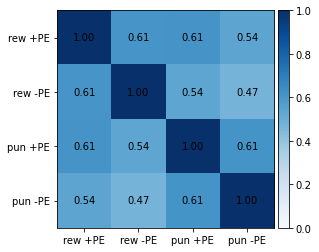

In [42]:
similarity_mean = np.nanmean(similarity, axis=0)

fig, ax = plt.subplots()
im = ax.imshow(similarity_mean, clim=[0, 1], cmap='Blues')
ax.set_xticks(range(n_mats_per_sub))
ax.set_yticks(range(n_mats_per_sub))
ax.set_xticklabels(['rew +PE', 'rew -PE', 'pun +PE', 'pun -PE'])
ax.set_yticklabels(['rew +PE', 'rew -PE', 'pun +PE', 'pun -PE'])
aligned_imshow_cbar(ax, im)

for i in range(n_mats_per_sub):
    for j in range(n_mats_per_sub):
        text = ax.text(
            j, 
            i, 
            f'{similarity_mean[i, j]:.2f}', 
            ha='center', 
            va='center')